In [12]:
from os import listdir
import keras
import tensorflow as tf
import os
import scipy.io
from scipy.ndimage import rotate
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
import random

In [ ]:
model = keras.models.load_model(f"model/resnet50/v1", compile=False)
model.summary()

In [14]:


def loadData(test_folder, 
             columns, 
             batch_size, 
             input_shape,
             samples
            ):
    
    test_files = [f"data/{test_folder}/{x}" for x in os.listdir(f"data/{test_folder}")]
    test_files = random.sample(test_files, samples)
    
    test_df = pd.read_parquet(f"data/{test_folder}_dataset.parquet.gzip")
    
    test_df.index =  f"data/{test_folder}/" + test_df["file"]
    
    test_df.drop(columns=['file'], inplace=True)

    test_y =test_df.loc[test_files][columns].to_numpy()

    
    def im_file_to_tensor(file, label):
        
        def _transform(im, label):
            im = tf.image.resize(im, [224,224])
            im = tf.cast(im, tf.float32) / 255.0
            label = tf.cast(label, tf.float32)
            return im, label
        
        def _im_file_to_tensor(file, label):
            path = file.numpy().decode()
            im = tf.image.decode_png(tf.io.read_file(path), channels=3)
            im, label = _transform(im, label)
            
            return im, label
        
        file, label =  tf.py_function(_im_file_to_tensor, 
                              inp=(file, label), 
                              Tout=(tf.float32, tf.float32))

        return ({"image" : file}, label)
    
        
    test = tf.data.Dataset.from_tensor_slices((test_files, test_y))

    test_ds  = test.map(im_file_to_tensor, num_parallel_calls=tf.data.AUTOTUNE)
    
    test_ds  = test_ds.batch(24, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

        
    return test_ds

In [47]:
from keras import backend as k


def saliencyViaBackprop(model, loss, y_true, img_example, eval_loss=False):

    loss_fn = tf.keras.losses.get(loss)
    img_example = np.array([img_example])
    
    # keep track of our gradients
    x_tensor = tf.convert_to_tensor(img_example, dtype=tf.float16)
    
    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        # make a prediction using the model and then calculate the
        # loss
        pred = model(x_tensor)
        loss = loss_fn(y_true, pred)
    # calculate the gradients using our tape and then update the
    # model weights
    
    if eval_loss:
        evaluated_gradients = tape.gradient(loss, x_tensor)
    else:
        evaluated_gradients = tape.gradient(pred, x_tensor)

    res = tf.abs(evaluated_gradients)
    return evaluated_gradients


def gen_occlusion(_img, s):
    n = s[0]
    y = s[1]
    x = s[2]
    img_ones = np.zeros((224, 224))
    img_ones[y : y + n, x : x + n] = 1

    _img[:, y : y + n, x : x + n, :] = 0.5  # gray
    return _img, img_ones


def schedule(size):
    """
    Returns List of (size, pos_y, pos_x)
    """
    start = 6
    x = 1
    w = 10

    diminishing_N = []
    for i in range(1):
        n = start - i * w
        if n > 0:
            diminishing_N.append(n)

    schedule = []
    for N in diminishing_N:
        steps = size // N
        for step_y in range(steps):
            for step_x in range(steps):
                schedule.append((N, 0 + step_y * N, 0 + step_x * N))

    return schedule


def error_f(y_true, y_pred):
    # y_true = np.zeros(10)
    # y_true[y] = 1

    error = np.absolute(y_true - y_pred)
    return error


def update_saliency(saliency_err, img_ones, err, output_size):

    occluded = np.array([img_ones] * output_size)
    error = err.reshape(output_size, 1, 1)
    new_error = occluded * error
    saliency_err += new_error
    return saliency_err


def saliencyViaOcclusion(_img, y, model):

    output_size = model.output.shape[1]
    _img = np.array([_img])
    y_hat = model.predict(_img)  # (224, 224, 3)
    saliency_err = np.zeros((output_size, 224, 224))
    saliency_cnt = np.zeros((output_size, 224, 224))

    list_occ_img = []
    for s in schedule(224):
        pimg = _img.copy()
        occ_img, img_ones = gen_occlusion(pimg, s)
        y2_hat = model.predict(occ_img, verbose=0)
        err = error_f(y_hat, y2_hat)
        saliency_cnt += np.array([img_ones] * output_size)
        saliency_err = update_saliency(saliency_err, img_ones, err, output_size)

    saliency_map = saliency_err / saliency_cnt
    return saliency_map


In [15]:
images = loadData(
    test_folder = 'testA_aws', 
    columns = ['waist'], 
    batch_size = 24, 
    input_shape = (224, 224, 3),
    samples = 2
)

In [22]:
samples = images.get_single_element()

In [48]:
sample=0
image_samples = samples[0]
pred_samples = samples[1]

ximage = image_samples['image'][sample]
y = pred_samples[sample]

def runSaliencyViaOcclusion(X, Y):
    res = saliencyViaOcclusion(X, Y, model)
    
    return res[0]

def runSaliencyViaBackprop(X, Y):
    res = saliencyViaBackprop(model, 'mse', Y, X, eval_loss=True)
    return res[0, :,:,0] + res[0, :,:,1] + res[0, :,:,2]

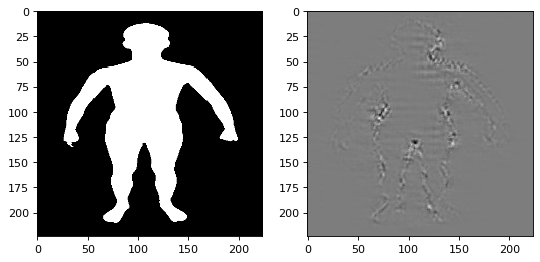

In [44]:
import matplotlib.pyplot as plt

#---------------RUN------------------
pos = runSaliencyViaBackprop(ximage, y)


plt.figure(figsize=(8, 6), dpi=80)
plt.subplot(1,2,1)
plt.imshow(ximage, interpolation='none')
plt.subplot(1,2,2)
plt.imshow(pos, interpolation='none', cmap='gray')

1/1 [==============================] - 0s 26ms/step


/tmp/ipykernel_11145/3616902978.py:99: RuntimeWarning: invalid value encountered in true_divide
  saliency_map = saliency_err / saliency_cnt


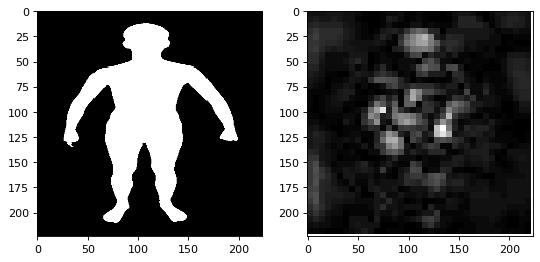

In [49]:
import matplotlib.pyplot as plt

#---------------RUN------------------
pos = runSaliencyViaOcclusion(ximage, y)


plt.figure(figsize=(8, 6), dpi=80)
plt.subplot(1,2,1)
plt.imshow(ximage, interpolation='none')
plt.subplot(1,2,2)
plt.imshow(pos, interpolation='none', cmap='gray')

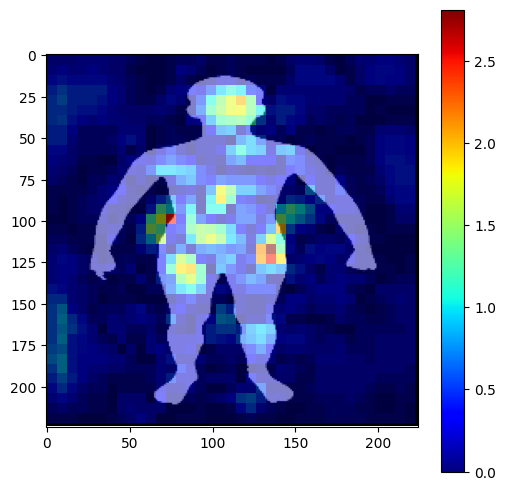

In [50]:
from matplotlib import cm

plt.figure(figsize=(6, 6))
plt.imshow(ximage, cmap=cm.gray)
plt.pcolormesh(pos, cmap=plt.cm.jet, alpha=0.50)
plt.colorbar().solids.set(alpha=1)

plt.show()